## LangGraph Open Deep Research - Supervisor-Researcher Architecture

In this notebook, we'll explore the **supervisor-researcher delegation architecture** for conducting deep research with LangGraph.

You can visit this repository to see the original application: [Open Deep Research](https://github.com/langchain-ai/open_deep_research)

Let's jump in!

## What We're Building

This implementation uses a **hierarchical delegation pattern** where:

1. **User Clarification** - Optionally asks clarifying questions to understand the research scope
2. **Research Brief Generation** - Transforms user messages into a structured research brief
3. **Supervisor** - A lead researcher that analyzes the brief and delegates research tasks
4. **Parallel Researchers** - Multiple sub-agents that conduct focused research simultaneously
5. **Research Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings are combined into a comprehensive report

![Architecture Diagram](https://private-user-images.githubusercontent.com/181020547/465824799-12a2371b-8be2-4219-9b48-90503eb43c69.png?jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3NjA0MTM5MjYsIm5iZiI6MTc2MDQxMzYyNiwicGF0aCI6Ii8xODEwMjA1NDcvNDY1ODI0Nzk5LTEyYTIzNzFiLThiZTItNDIxOS05YjQ4LTkwNTAzZWI0M2M2OS5wbmc_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjUxMDE0JTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI1MTAxNFQwMzQ3MDZaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT1iMmNkMzYyMTU3M2NkYTg3NTIxYWZjNjljZDVkNjM1MDNmMmE0NDgyZmJhNGI5MDVlMTE2ZTVhZGRkODFkYjUwJlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCJ9.4C0ijHi-7G1KgtuL-u8FICPU_6ca9ulJcgZlJ203P0A)

This differs from a section-based approach by allowing dynamic task decomposition based on the research question, rather than predefined sections.

![Architecture Diagram](https://private-user-images.githubusercontent.com/181020547/465825499-052f2ed3-c664-4a4f-8ec2-074349dcaa3f.png?jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3NjA0MTc1NjQsIm5iZiI6MTc2MDQxNzI2NCwicGF0aCI6Ii8xODEwMjA1NDcvNDY1ODI1NDk5LTA1MmYyZWQzLWM2NjQtNGE0Zi04ZWMyLTA3NDM0OWRjYWEzZi5wbmc_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjUxMDE0JTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI1MTAxNFQwNDQ3NDRaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT1kMDhkN2FmZDI4ZTMxNzU5OWNkNjcxNzkwMmFmYjYxOTY5M2RkNWVlNjFhM2NjNWQ1YzY3ZTc1NDQ1ZjgyZTRkJlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCJ9.1FROi7xUKIKObiQ8a1IFqeQthmThJrhIJvopIAgC3Kw)

## Dependencies

You'll need API keys for Anthropic (for the LLM) and Tavily (for web search). We'll configure the system to use Anthropic's Claude Sonnet 4 exclusively.

In [2]:
import os
import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## Task 1: State Definitions

The state structure is hierarchical with three levels:

### Agent State (Top Level)
Contains the overall conversation messages, research brief, accumulated notes, and final report.

### Supervisor State (Middle Level)
Manages the research supervisor's messages, research iterations, and coordinating parallel researchers.

### Researcher State (Bottom Level)
Each individual researcher has their own message history, tool call iterations, and research findings.

We also have structured outputs for tool calling:
- **ConductResearch** - Tool for supervisor to delegate research to a sub-agent
- **ResearchComplete** - Tool to signal research phase is done
- **ClarifyWithUser** - Structured output for asking clarifying questions
- **ResearchQuestion** - Structured output for the research brief

Let's import these from our library: [`open_deep_library/state.py`](open_deep_library/state.py)

In [3]:
# Import state definitions from the library
from open_deep_library.state import (
    # Main workflow states
    AgentState,           # Lines 65-72: Top-level agent state with messages, research_brief, notes, final_report
    AgentInputState,      # Lines 62-63: Input state is just messages
    
    # Supervisor states
    SupervisorState,      # Lines 74-81: Supervisor manages research delegation and iterations
    
    # Researcher states
    ResearcherState,      # Lines 83-90: Individual researcher with messages and tool iterations
    ResearcherOutputState, # Lines 92-96: Output from researcher (compressed research + raw notes)
    
    # Structured outputs for tool calling
    ConductResearch,      # Lines 15-19: Tool for delegating research to sub-agents
    ResearchComplete,     # Lines 21-22: Tool to signal research completion
    ClarifyWithUser,      # Lines 30-41: Structured output for user clarification
    ResearchQuestion,     # Lines 43-48: Structured output for research brief
)

#### ❓ Question 1:

 Explain the interrelationships between the three states.  Why don't we just make a single huge state?

✅ Answer: The key insight here is that states are isolated but connected through a hierarchical graph structure where information flows downward (during delegation) and upward (for compressed summaries only). You can think of the key inter-relationships as follows: 

```
 AgentState
├── Initializes → SupervisorState (passes research_brief)
└── Receives back → compressed notes

    SupervisorState
    ├── Spawns 5x → ResearcherState (parallel, isolated)
    └── Collects → compressed_research from each individual researcher
    
        ResearcherState #1, #2, #3, #4, #5 (parallel)
        └── Each returns → compressed findings + raw notes
```

The key benefits of using a hierarchical state structure insead of a single LARGE state is as follows:

- Parallelism: Each researcher has independent memory space, without overwriting each other's data
- Isolation: Researchers can't see or break or modify each other's data
- Compression: Allows raw search information (that can go upto thousands of tokens) to be compressed into smaller more manageable final report, with less relevant information discarded. This also limits surpassing token limits.

## Task 2: Utility Functions and Tools

The system uses several key utilities:

### Search Tools
- **tavily_search** - Async web search with automatic summarization to stay within token limits
- Supports Anthropic native web search and Tavily API

### Reflection Tools
- **think_tool** - Allows researchers to reflect on their progress and plan next steps (ReAct pattern)

### Helper Utilities
- **get_all_tools** - Assembles the complete toolkit (search + MCP + reflection)
- **get_today_str** - Provides current date context for research
- Token limit handling utilities for graceful degradation

These are defined in [`open_deep_library/utils.py`](open_deep_library/utils.py)

In [4]:
# Import utility functions and tools from the library
from open_deep_library.utils import (
    # Search tool - Lines 43-136: Tavily search with automatic summarization
    tavily_search,
    
    # Reflection tool - Lines 219-244: Strategic thinking tool for ReAct pattern
    think_tool,
    
    # Tool assembly - Lines 569-597: Get all configured tools
    get_all_tools,
    
    # Date utility - Lines 872-879: Get formatted current date
    get_today_str,
    
    # Supporting utilities for error handling
    get_api_key_for_model,          # Lines 892-914: Get API keys from config or env
    is_token_limit_exceeded,         # Lines 665-701: Detect token limit errors
    get_model_token_limit,           # Lines 831-846: Look up model's token limit
    remove_up_to_last_ai_message,    # Lines 848-866: Truncate messages for retry
    anthropic_websearch_called,      # Lines 607-637: Detect Anthropic native search usage
    openai_websearch_called,         # Lines 639-658: Detect OpenAI native search usage
    get_notes_from_tool_calls,       # Lines 599-601: Extract notes from tool messages
)

### ❓ Question 2:  

What are the advantages and disadvantages of importing these components instead of including them in the notebook?

✅ Answer: Advantages of importing components:

- Reusability - Code can be used across multiple notebooks, scripts, or applications without duplication
- Maintainability - Changes only need to be made once in the library, automatically affecting all importers
- Organization - Related functionality is logically grouped into modules (state.py, utils.py, prompts.py, etc.)
- Testing - Library code can be properly unit tested in isolation
- Can share as a package


Disadvantages of importing components:

- Increases overhead - cannot run notebook in standalone fashion
- Debugging complexity - stack traces can span multiple files
- Quick experimental changes requiree editing the python files and possibly reloading/reimporting modules




## Task 3: Configuration System

The configuration system controls:

### Research Behavior
- **allow_clarification** - Whether to ask clarifying questions before research
- **max_concurrent_research_units** - How many parallel researchers can run (default: 5)
- **max_researcher_iterations** - How many times supervisor can delegate research (default: 6)
- **max_react_tool_calls** - Tool call limit per researcher (default: 10)

### Model Configuration
- **research_model** - Model for research and supervision (we'll use Anthropic)
- **compression_model** - Model for synthesizing findings
- **final_report_model** - Model for writing the final report
- **summarization_model** - Model for summarizing web search results

### Search Configuration
- **search_api** - Which search API to use (ANTHROPIC, TAVILY, or NONE)
- **max_content_length** - Character limit before summarization

Defined in [`open_deep_library/configuration.py`](open_deep_library/configuration.py)

In [5]:
# Import configuration from the library
from open_deep_library.configuration import (
    Configuration,    # Lines 38-247: Main configuration class with all settings
    SearchAPI,        # Lines 11-17: Enum for search API options (ANTHROPIC, TAVILY, NONE)
)

## Task 4: Prompt Templates

The system uses carefully engineered prompts for each phase:

### Phase 1: Clarification
**clarify_with_user_instructions** - Analyzes if the research scope is clear or needs clarification

### Phase 2: Research Brief
**transform_messages_into_research_topic_prompt** - Converts user messages into a detailed research brief

### Phase 3: Supervisor
**lead_researcher_prompt** - System prompt for the supervisor that manages delegation strategy

### Phase 4: Researcher
**research_system_prompt** - System prompt for individual researchers conducting focused research

### Phase 5: Compression
**compress_research_system_prompt** - Prompt for synthesizing research findings without losing information

### Phase 6: Final Report
**final_report_generation_prompt** - Comprehensive prompt for writing the final report

All prompts are defined in [`open_deep_library/prompts.py`](open_deep_library/prompts.py)

In [6]:
# Import prompt templates from the library
from open_deep_library.prompts import (
    clarify_with_user_instructions,                    # Lines 3-41: Ask clarifying questions
    transform_messages_into_research_topic_prompt,     # Lines 44-77: Generate research brief
    lead_researcher_prompt,                            # Lines 79-136: Supervisor system prompt
    research_system_prompt,                            # Lines 138-183: Researcher system prompt
    compress_research_system_prompt,                   # Lines 186-222: Research compression prompt
    final_report_generation_prompt,                    # Lines 228-308: Final report generation
)

## Task 5: Node Functions - The Building Blocks

Now let's look at the node functions that make up our graph. We'll import them from the library and understand what each does.

### The Complete Research Workflow

The workflow consists of 8 key nodes organized into 3 subgraphs:

1. **Main Graph Nodes:**
   - `clarify_with_user` - Entry point that checks if clarification is needed
   - `write_research_brief` - Transforms user input into structured research brief
   - `final_report_generation` - Synthesizes all research into final report

2. **Supervisor Subgraph Nodes:**
   - `supervisor` - Lead researcher that plans and delegates
   - `supervisor_tools` - Executes supervisor's tool calls (delegation, reflection)

3. **Researcher Subgraph Nodes:**
   - `researcher` - Individual researcher conducting focused research
   - `researcher_tools` - Executes researcher's tool calls (search, reflection)
   - `compress_research` - Synthesizes researcher's findings

All nodes are defined in [`open_deep_library/deep_researcher.py`](open_deep_library/deep_researcher.py)

### Node 1: clarify_with_user

**Purpose:** Analyzes user messages and asks clarifying questions if the research scope is unclear.

**Key Steps:**
1. Check if clarification is enabled in configuration
2. Use structured output to analyze if clarification is needed
3. If needed, end with a clarifying question for the user
4. If not needed, proceed to research brief with verification message

**Implementation:** [`open_deep_library/deep_researcher.py` lines 60-115](open_deep_library/deep_researcher.py#L60-L115)

In [7]:
# Import the clarify_with_user node
from open_deep_library.deep_researcher import clarify_with_user

### Node 2: write_research_brief

**Purpose:** Transforms user messages into a structured research brief for the supervisor.

**Key Steps:**
1. Use structured output to generate detailed research brief from messages
2. Initialize supervisor with system prompt and research brief
3. Set up supervisor messages with proper context

**Why this matters:** A well-structured research brief helps the supervisor make better delegation decisions.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 118-175](open_deep_library/deep_researcher.py#L118-L175)

In [8]:
# Import the write_research_brief node
from open_deep_library.deep_researcher import write_research_brief

### Node 3: supervisor

**Purpose:** Lead research supervisor that plans research strategy and delegates to sub-researchers.

**Key Steps:**
1. Configure model with three tools:
   - `ConductResearch` - Delegate research to a sub-agent
   - `ResearchComplete` - Signal that research is done
   - `think_tool` - Strategic reflection before decisions
2. Generate response based on current context
3. Increment research iteration count
4. Proceed to tool execution

**Decision Making:** The supervisor uses `think_tool` to reflect before delegating research, ensuring thoughtful decomposition of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 178-223](open_deep_library/deep_researcher.py#L178-L223)

In [9]:
# Import the supervisor node (from supervisor subgraph)
from open_deep_library.deep_researcher import supervisor

### Node 4: supervisor_tools

**Purpose:** Executes the supervisor's tool calls, including strategic thinking and research delegation.

**Key Steps:**
1. Check exit conditions:
   - Exceeded maximum iterations
   - No tool calls made
   - `ResearchComplete` called
2. Process `think_tool` calls for strategic reflection
3. Execute `ConductResearch` calls in parallel:
   - Spawn researcher subgraphs for each delegation
   - Limit to `max_concurrent_research_units` (default: 5)
   - Gather all results asynchronously
4. Aggregate findings and return to supervisor

**Parallel Execution:** This is where the magic happens - multiple researchers work simultaneously on different aspects of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 225-349](open_deep_library/deep_researcher.py#L225-L349)

In [10]:
# Import the supervisor_tools node
from open_deep_library.deep_researcher import supervisor_tools

### Node 5: researcher

**Purpose:** Individual researcher that conducts focused research on a specific topic.

**Key Steps:**
1. Load all available tools (search, MCP, reflection)
2. Configure model with tools and researcher system prompt
3. Generate response with tool calls
4. Increment tool call iteration count

**ReAct Pattern:** Researchers use `think_tool` to reflect after each search, deciding whether to continue or provide their answer.

**Available Tools:**
- Search tools (Tavily or Anthropic native search)
- `think_tool` for strategic reflection
- `ResearchComplete` to signal completion
- MCP tools (if configured)

**Implementation:** [`open_deep_library/deep_researcher.py` lines 365-424](open_deep_library/deep_researcher.py#L365-L424)

In [11]:
# Import the researcher node (from researcher subgraph)
from open_deep_library.deep_researcher import researcher

### Node 6: researcher_tools

**Purpose:** Executes the researcher's tool calls, including searches and strategic reflection.

**Key Steps:**
1. Check early exit conditions (no tool calls, native search used)
2. Execute all tool calls in parallel:
   - Search tools fetch and summarize web content
   - `think_tool` records strategic reflections
   - MCP tools execute external integrations
3. Check late exit conditions:
   - Exceeded `max_react_tool_calls` (default: 10)
   - `ResearchComplete` called
4. Continue research loop or proceed to compression

**Error Handling:** Safely handles tool execution errors and continues with available results.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 435-509](open_deep_library/deep_researcher.py#L435-L509)

In [12]:
# Import the researcher_tools node
from open_deep_library.deep_researcher import researcher_tools

### Node 7: compress_research

**Purpose:** Compresses and synthesizes research findings into a concise, structured summary.

**Key Steps:**
1. Configure compression model
2. Add compression instruction to messages
3. Attempt compression with retry logic:
   - If token limit exceeded, remove older messages
   - Retry up to 3 times
4. Extract raw notes from tool and AI messages
5. Return compressed research and raw notes

**Why Compression?** Researchers may accumulate lots of tool outputs and reflections. Compression ensures:
- All important information is preserved
- Redundant information is deduplicated
- Content stays within token limits for the final report

**Token Limit Handling:** Gracefully handles token limit errors by progressively truncating messages.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 511-585](open_deep_library/deep_researcher.py#L511-L585)

In [13]:
# Import the compress_research node
from open_deep_library.deep_researcher import compress_research

### Node 8: final_report_generation

**Purpose:** Generates the final comprehensive research report from all collected findings.

**Key Steps:**
1. Extract all notes from completed research
2. Configure final report model
3. Attempt report generation with retry logic:
   - If token limit exceeded, truncate findings by 10%
   - Retry up to 3 times
4. Return final report or error message

**Token Limit Strategy:**
- First retry: Use model's token limit × 4 as character limit
- Subsequent retries: Reduce by 10% each time
- Graceful degradation with helpful error messages

**Report Quality:** The prompt guides the model to create well-structured reports with:
- Proper headings and sections
- Inline citations
- Comprehensive coverage of all findings
- Sources section at the end

**Implementation:** [`open_deep_library/deep_researcher.py` lines 607-697](open_deep_library/deep_researcher.py#L607-L697)

In [14]:
# Import the final_report_generation node
from open_deep_library.deep_researcher import final_report_generation

## Task 6: Graph Construction - Putting It All Together

The system is organized into three interconnected graphs:

### 1. Researcher Subgraph (Bottom Level)
Handles individual focused research on a specific topic:
```
START → researcher → researcher_tools → compress_research → END
               ↑            ↓
               └────────────┘ (loops until max iterations or ResearchComplete)
```

### 2. Supervisor Subgraph (Middle Level)
Manages research delegation and coordination:
```
START → supervisor → supervisor_tools → END
            ↑              ↓
            └──────────────┘ (loops until max iterations or ResearchComplete)
            
supervisor_tools spawns multiple researcher_subgraphs in parallel
```

### 3. Main Deep Researcher Graph (Top Level)
Orchestrates the complete research workflow:
```
START → clarify_with_user → write_research_brief → research_supervisor → final_report_generation → END
                 ↓                                       (supervisor_subgraph)
               (may end early if clarification needed)
```

Let's import the compiled graphs from the library.

In [15]:
# Import the pre-compiled graphs from the library
from open_deep_library.deep_researcher import (
    # Bottom level: Individual researcher workflow
    researcher_subgraph,    # Lines 588-605: researcher → researcher_tools → compress_research
    
    # Middle level: Supervisor coordination
    supervisor_subgraph,    # Lines 351-363: supervisor → supervisor_tools (spawns researchers)
    
    # Top level: Complete research workflow
    deep_researcher,        # Lines 699-719: Main graph with all phases
)

## Why This Architecture?

### Advantages of Supervisor-Researcher Delegation

1. **Dynamic Task Decomposition**
   - Unlike section-based approaches with predefined structure, the supervisor can break down research based on the actual question
   - Adapts to different types of research (comparisons, lists, deep dives, etc.)

2. **Parallel Execution**
   - Multiple researchers work simultaneously on different aspects
   - Much faster than sequential section processing
   - Configurable parallelism (1-20 concurrent researchers)

3. **ReAct Pattern for Quality**
   - Researchers use `think_tool` to reflect after each search
   - Prevents excessive searching and improves search quality
   - Natural stopping conditions based on information sufficiency

4. **Flexible Tool Integration**
   - Easy to add MCP tools for specialized research
   - Supports multiple search APIs (Anthropic, Tavily)
   - Each researcher can use different tool combinations

5. **Graceful Token Limit Handling**
   - Compression prevents token overflow
   - Progressive truncation in final report generation
   - Research can scale to arbitrary depths

### Trade-offs

- **Complexity:** More moving parts than section-based approach
- **Cost:** Parallel researchers use more tokens (but faster)
- **Unpredictability:** Research structure emerges dynamically

## Task 7: Running the Deep Researcher

Now let's see the system in action! We'll use it to analyze a PDF document about how people use AI.

### Setup

We need to:
1. Load the PDF document
2. Configure the execution with Anthropic settings
3. Run the research workflow

In [16]:
# Load the PDF document
from pathlib import Path
import PyPDF2

def load_pdf(pdf_path: str) -> str:
    """Load and extract text from PDF."""
    pdf_text = ""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page in pdf_reader.pages:
            pdf_text += page.extract_text() + "\n\n"
    return pdf_text

# Load the PDF about how people use AI
pdf_path = "data/howpeopleuseai.pdf"
pdf_content = load_pdf(pdf_path)

print(f"Loaded PDF with {len(pdf_content)} characters")
print(f"First 500 characters:\n{pdf_content[:500]}...")

Loaded PDF with 112460 characters
First 500 characters:
NBER WORKING PAPER SERIES
HOW PEOPLE USE CHATGPT
Aaron Chatterji
Thomas Cunningham
David J. Deming
Zoe Hitzig
Christopher Ong
Carl Yan Shan
Kevin Wadman
Working Paper 34255
http://www.nber.org/papers/w34255
NATIONAL BUREAU OF ECONOMIC RESEARCH
1050 Massachusetts Avenue
Cambridge, MA 02138
September 2025
We acknowledge help and comments from Joshua Achiam, Hemanth Asirvatham, Ryan 
Beiermeister,  Rachel Brown, Cassandra Duchan Solis, Jason Kwon, Elliott Mokski, Kevin Rao, 
Harrison Satcher,  Gawe...


In [17]:
# Set up the graph with Anthropic configuration
from IPython.display import Markdown, display
import uuid

# Note: deep_researcher is already compiled from the library
# For this demo, we'll use it directly without additional checkpointing
graph = deep_researcher

print("✓ Graph ready for execution")
print("  (Note: The graph is pre-compiled from the library)")

✓ Graph ready for execution
  (Note: The graph is pre-compiled from the library)


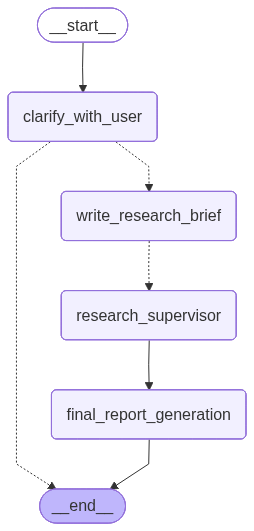

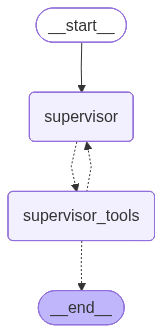

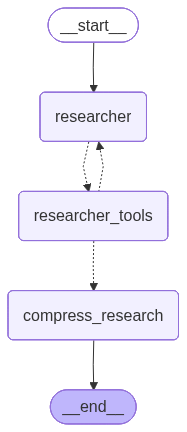

In [22]:
# For Jupyter notebooks
from IPython.display import Image, display

# Main graph
display(Image(deep_researcher.get_graph().draw_mermaid_png()))

# Supervisor subgraph
display(Image(supervisor_subgraph.get_graph().draw_mermaid_png()))

# Researcher subgraph
display(Image(researcher_subgraph.get_graph().draw_mermaid_png()))

### Configuration for Anthropic

We'll configure the system to use:
- **Claude Sonnet 4** for all research, supervision, and report generation
- **Tavily** for web search (you can also use Anthropic's native search)
- **Moderate parallelism** (3 concurrent researchers)
- **Clarification enabled** (will ask if research scope is unclear)

In [18]:
# Configure for Anthropic with moderate settings
config = {
    "configurable": {
        # Model configuration - using Claude Sonnet 4 for everything
        "research_model": "anthropic:claude-sonnet-4-20250514",
        "research_model_max_tokens": 10000,
        
        "compression_model": "anthropic:claude-sonnet-4-20250514",
        "compression_model_max_tokens": 8192,
        
        "final_report_model": "anthropic:claude-sonnet-4-20250514",
        "final_report_model_max_tokens": 10000,
        
        "summarization_model": "anthropic:claude-sonnet-4-20250514",
        "summarization_model_max_tokens": 8192,
        
        # Research behavior
        "allow_clarification": True,
        "max_concurrent_research_units": 1,  # 1 parallel researchers
        "max_researcher_iterations": 2,      # Supervisor can delegate up to 2 times
        "max_react_tool_calls": 3,           # Each researcher can make up to 3 tool calls
        
        # Search configuration
        "search_api": "tavily",  # Using Tavily for web search
        "max_content_length": 50000,
        
        # Thread ID for this conversation
        "thread_id": str(uuid.uuid4())
    }
}

print("✓ Configuration ready")
print(f"  - Research Model: Claude Sonnet 4")
print(f"  - Max Concurrent Researchers: 3")
print(f"  - Max Iterations: 4")
print(f"  - Search API: Tavily")

✓ Configuration ready
  - Research Model: Claude Sonnet 4
  - Max Concurrent Researchers: 3
  - Max Iterations: 4
  - Search API: Tavily


### Execute the Research

Now let's run the research! We'll ask the system to analyze the PDF and provide insights about how people use AI.

The workflow will:
1. **Clarify** - Check if the request is clear (may skip if obvious)
2. **Research Brief** - Transform our request into a structured brief
3. **Supervisor** - Plan research strategy and delegate to researchers
4. **Parallel Research** - Multiple researchers gather information simultaneously
5. **Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings combined into comprehensive report

In [19]:
# Create our research request with PDF context
research_request = f"""
I have a PDF document about how people use AI. Please analyze this document and provide insights about:

1. What are the main findings about how people are using AI?
2. What are the most common use cases?
3. What trends or patterns emerge from the data?

Here's the PDF content:

{pdf_content[:10000]}  # First 10k chars to stay within limits

...[content truncated for context window]
"""

# Execute the graph
async def run_research():
    """Run the research workflow and display results."""
    print("Starting research workflow...\n")
    
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": research_request}]},
        config,
        stream_mode="updates"
    ):
        # Display each step
        for node_name, node_output in event.items():
            print(f"\n{'='*60}")
            print(f"Node: {node_name}")
            print(f"{'='*60}")
            
            if node_name == "clarify_with_user":
                if "messages" in node_output:
                    last_msg = node_output["messages"][-1]
                    print(f"\n{last_msg.content}")
            
            elif node_name == "write_research_brief":
                if "research_brief" in node_output:
                    print(f"\nResearch Brief Generated:")
                    print(f"{node_output['research_brief'][:500]}...")
            
            elif node_name == "supervisor":
                print(f"\nSupervisor planning research strategy...")
                if "supervisor_messages" in node_output:
                    last_msg = node_output["supervisor_messages"][-1]
                    if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                        print(f"Tool calls: {len(last_msg.tool_calls)}")
                        for tc in last_msg.tool_calls:
                            print(f"  - {tc['name']}")
            
            elif node_name == "supervisor_tools":
                print(f"\nExecuting supervisor's tool calls...")
                if "notes" in node_output:
                    print(f"Research notes collected: {len(node_output['notes'])}")
            
            elif node_name == "final_report_generation":
                if "final_report" in node_output:
                    print(f"\n" + "="*60)
                    print("FINAL REPORT GENERATED")
                    print("="*60 + "\n")
                    display(Markdown(node_output["final_report"]))
    
    print("\n" + "="*60)
    print("Research workflow completed!")
    print("="*60)

# Run the research
await run_research()

Starting research workflow...


Node: clarify_with_user

I have sufficient information to proceed with analyzing the PDF document about ChatGPT usage. You've provided a clear NBER working paper titled "How People Use ChatGPT" and requested insights on: (1) main findings about how people are using AI, (2) most common use cases, and (3) trends or patterns from the data. The document contains comprehensive research data on ChatGPT usage patterns, growth statistics, and classification of user interactions from May 2024 to June 2025. I will now begin analyzing this research to provide you with detailed insights on AI usage patterns, common use cases, and emerging trends.

Node: write_research_brief

Research Brief Generated:
I need a comprehensive analysis of the NBER working paper "How People Use ChatGPT" by Aaron Chatterji et al. (Working Paper 34255, September 2025) to extract specific insights about AI usage patterns. Please analyze this document to provide detailed findings on: (1) Wha


Node: research_supervisor

Node: final_report_generation

FINAL REPORT GENERATED



# How People Use ChatGPT: Comprehensive Analysis of NBER Working Paper 34255

## Executive Summary

The NBER Working Paper "How People Use ChatGPT" by Aaron Chatterji et al. represents the most comprehensive analysis to date of AI chatbot usage patterns, examining ChatGPT's unprecedented growth from its November 2022 launch through July 2025. The study reveals that ChatGPT has achieved adoption by approximately 10% of the world's adult population, with users sending over 18 billion messages weekly by July 2025. The research utilized a privacy-preserving automated classification system to analyze conversation patterns, revealing significant shifts in usage demographics and applications over time.

## Growth Patterns and Adoption Rates

### Unprecedented Scale and Speed of Adoption

ChatGPT's growth trajectory has no precedent in technology adoption history. Within just five days of its November 30, 2022 launch, the platform reached one million registered users [1]. By early November 2023, less than one year after release, ChatGPT had achieved 100 million weekly active users (WAUs) [1]. The platform's growth continued exponentially, with weekly active users doubling every 7-8 months since launch [1].

By July 2025, ChatGPT had reached over 750 million weekly active users, representing approximately 10% of the world's adult population [1][2]. Daily message volume reached 2.6 billion messages by June 2025, equivalent to more than 30,000 messages per second [1][2]. To contextualize this scale, ChatGPT's current message volume approaches that of Google search, which processes approximately 14 billion searches daily [1].

### Message Volume Growth Outpaces User Growth

A particularly significant finding is that message volume has grown faster than user adoption, increasing 5.8x in the past year compared to 3.2x growth in users [1]. This indicates intensifying engagement among existing users rather than simple user base expansion. Early adopters from Q1 2023 are now sending 40% more messages per day than they did two years earlier, while users who signed up in late 2024 are sending nearly twice as many messages as when they first started [1][2].

The study identified flat engagement through most of 2024, followed by substantial increases beginning in late 2024/early 2025 across all signup cohorts, suggesting significant improvements in ChatGPT's capabilities and user-friendliness [1].

## Demographic Trends and Shifts

### Gender Gap Closure

One of the most striking demographic shifts documented in the study is the dramatic narrowing of the gender gap. Initially, over 80% of users had typically male names when ChatGPT first launched [1][2][3]. However, by early 2025, weekly active users reached relative gender parity, and as of July 2025, 52% of active users had typically female first names, indicating the gender gap may have closed completely [1][2][3].

The researchers used a privacy-preserving approach to analyze gender patterns by matching user names to public datasets like the World Gender Name Dictionary, excluding approximately 30% of names that could not be confidently assigned a gender [1].

### Age Distribution

Age demographics reveal that nearly half of all messages sent by adults (46%) come from users under the age of 26 [3][4]. While age gaps have narrowed somewhat in recent months, older users demonstrate a higher propensity for work-related usage [3][4]. This pattern suggests different use case preferences across age cohorts.

### Geographic and Economic Patterns

The study reveals particularly interesting patterns in global adoption. ChatGPT usage has grown much faster in middle-income countries compared to the richest countries [1]. Usage increased by 3x (from 10% to 30% of the internet-using population) in countries from the richest decile, but by 5-6x for countries in the middle deciles [1]. The fastest growth in adoption is occurring in low- and middle-income countries, with growth rates four times higher than in the highest-income countries [3][4].

Remarkably, there is now minimal difference in ChatGPT usage between countries at the 50th versus 90th percentile of GDP per capita [1]. For example, Brazil, South Korea, and the United States have relatively similar ChatGPT usage rates despite GDP per capita of $10,000, $34,000, and $86,000 respectively [1].

## Work vs Non-Work Usage Distribution

### Shift Toward Non-Work Usage

One of the most significant findings concerns the evolution of work versus non-work usage patterns. Non-work-related messages have grown from 53% in mid-2024 to over 70% of all usage by mid-2025 [1][2][3][4]. While work-related messages show steady growth, non-work-related messages have experienced even faster expansion [2].

This shift represents a fundamental change in how ChatGPT is perceived and utilized by users. While most economic analysis of AI has focused on productivity impacts in paid work, the study suggests that impact on activity outside of work (home production) may be on a similar or larger scale [2].

### Work Usage Characteristics by Demographics

Work-related usage correlates strongly with education and occupation levels. Graduate degree holders send 48% work-related messages compared to 37% for those with less than a bachelor's degree [3]. Highly educated professionals are disproportionately likely to use ChatGPT for work and for "asking" rather than "doing" tasks [3][4].

More educated users focus on work-related use, especially writing and decision support, with graduate users asking more "why/how" questions than producing outputs [3]. The study found that managers and business roles use ChatGPT mainly for writing, while technical roles utilize it for coding and information retrieval [3].

## Most Common Use Cases

### Three Dominant Categories

The study's conversation classification revealed that nearly 80% of all ChatGPT usage falls into three broad categories: Practical Guidance, Seeking Information, and Writing [1][2][3][4].

**Practical Guidance (28.3-29%)** emerges as the most common use case overall, encompassing activities like tutoring, teaching, how-to advice across various topics, and creative ideation [3][4]. This category includes step-by-step help, planning, and advice, with popular applications including personal advice, learning, and daily problem-solving [3].

**Seeking Information (21.3-24.4%)** includes searching for information about people, current events, products, and recipes, functioning as a very close substitute for web search [3][4]. This category encompasses fact-finding, explanations, news, facts, recipes, and product research [3][4].

**Writing (24-28.1%)** involves drafting, editing, refining text, emails, reports, social media posts, and translating existing text [3][4]. Writing assistance accounts for 28% of all conversations overall and represents the most significant use case in work contexts [3].

### Work-Specific Use Case Patterns

In work contexts, Writing dominates as the primary use case, accounting for 40-42% of work-related messages in June 2025 [3][4]. This highlights chatbots' unique ability to generate digital outputs compared to traditional search engines [2]. Interestingly, about two-thirds of Writing messages involve modifying user-provided text rather than creating new text from scratch [3][4].

Practical Guidance accounts for approximately 24% of work-related usage, primarily consisting of tutoring or teaching (36%) and general how-to advice (30%) [2]. About 58% of work-related messages are associated with two broad work activities: obtaining, documenting, and interpreting information; and making decisions, giving advice, solving problems, and thinking creatively [3].

### Lower-Volume Use Cases

Several use cases represent surprisingly small shares of total usage. Computer Programming accounts for only about 4.2% of messages [2][3][4], which is notably lower than competing AI tools such as Claude [3][4]. Self-Expression and Relationships account for only 1.9% of messages, while Games and Role Play represent just 0.4% [3]. The share of messages related to companionship and social-emotional issues is similarly small at 1.9% [3].

## User Intent Classification and Interaction Patterns

### Three-Part Intent Framework

The research classified messages according to three intent types that reveal how users approach ChatGPT interactions:

**"Asking" (49% of messages)** involves seeking information, advice, or guidance, with examples including "who was xyz," "how do I create a budget," and "what was the inflation rate" [3][4]. "Asking" messages have shown faster growth over the past year and are rated as having higher quality by user satisfaction classifiers and direct user feedback [3].

**"Doing" (40% of messages)** encompasses requesting tasks or output that can be integrated into processes, such as "draft a report," "rewrite email," or "extract data" [3][4]. In work contexts, "Doing" activities dominate at approximately 56% of work-related messages, especially in Writing tasks [2][3].

**"Expressing" (11% of messages)** includes sharing views, feelings, personal reflection and play, or messages with no clear intent [3][4].

## Temporal Trends and Evolution

### Usage Pattern Changes Over Time

The study period from May 2024 to June 2025 revealed several significant temporal trends. User satisfaction has improved markedly over time, with positive user ratings ("good" interactions) now over four times more common than negative ones [3]. Positive interactions outnumber negative ones by approximately 4:1 [2].

The daily activity of long-term users has plateaued, with almost all recent growth coming from new sign-ups experimenting with ChatGPT [3]. Between July 2024 and July 2025, the number of messages sent through ChatGPT grew 5× [5].

### Evolution in Interaction Sophistication

Most interactions have evolved toward open-ended approaches, with significant impact expected when free-form chats translate into usable outputs such as study guides, marketing plans, or company workflows [3]. This shift toward open-ended, outcome-focused interactions represents a fundamental change in how people interact with AI [3].

## Economic Implications and Consumer Surplus

### Quantified Economic Value

The study provides concrete evidence of ChatGPT's economic impact, estimating $97 billion in consumer surplus, with US users alone needing to be paid $98 monthly to give up generative AI access [3]. This substantial valuation reflects the significant value users derive from the platform across both work and non-work contexts.

ChatGPT provides economic value primarily through decision support, which proves especially important in knowledge-intensive jobs [1][2][4]. About 14.9% of work-related usage involves "making decisions and solving problems," indicating people are using the tool as a co-pilot for guidance [3]. "Making Decisions and Solving Problems" ranks in the top 2 work activities across virtually every job type [3].

## Methodology and Privacy Protections

### Privacy-Preserving Research Approach

The research methodology employed sophisticated privacy protections using a Data Clean Room (DCR) approach, where no researcher directly accessed user data or message content [1]. All personally identifiable information was automatically scrubbed using OpenAI's internal Privacy Filter tool, and analyses were conducted through automated classifiers that only provided aggregated outputs [1].

The external researcher (Deming) never directly handled the data, and all code required multiple inspection cycles and was publicly logged [1]. The team used WildChat, a public dataset of 1 million real ChatGPT interactions, to fine-tune their automated classification prompts [1].

### Sample and Scope

The research analyzed a large random sample of anonymized messages from ChatGPT consumer plans (Free, Plus, and Pro) between May 2024 and June 2025 [1][2]. The study was approved by Harvard IRB (IRB25-0983) and represents collaboration between researchers from Duke University, Harvard University, and OpenAI [1].

## Study Limitations and Future Research

The researchers acknowledged that working in the Data Clean Room was restrictive and prevented some deeper analyses they wanted to conduct, particularly around understanding whether ChatGPT substitutes for or complements expertise [1]. The study focused exclusively on consumer plans and did not include business, enterprise, or educational plans.

The 64-page paper represents the most comprehensive analysis of AI chatbot usage patterns to date, providing unprecedented insights into how this transformative technology is being adopted and utilized across diverse populations and use cases.

### Sources

[1] How People Use ChatGPT - by David Deming - Forked Lightning: https://forklightning.substack.com/p/how-people-use-chatgpt

[2] How People Use ChatGPT | NBER: https://www.nber.org/papers/w34255

[3] OpenAI releases research on ChatGPT usage worldwide - LinkedIn: https://www.linkedin.com/posts/aaron-ronnie-chatterji_this-morning-the-openai-economic-research-activity-7373377911476649986-_n_s

[4] How People Really Use ChatGPT: Findings from NBER Research: https://techmaniacs.com/2025/09/15/how-people-really-use-chatgpt-findings-from-nber-research/

[5] How People Are Really Using ChatGPT - Mike Jeffs: https://mikejeffs.com/blog/how-people-are-really-using-chatgpt/


Research workflow completed!


## Understanding the Output

Let's break down what happened:

### Phase 1: Clarification
The system checked if your request was clear. Since you provided a PDF and specific questions, it likely proceeded without clarification.

### Phase 2: Research Brief
Your request was transformed into a detailed research brief that guides the supervisor's delegation strategy.

### Phase 3: Supervisor Delegation
The supervisor analyzed the brief and decided how to break down the research:
- Used `think_tool` to plan strategy
- Called `ConductResearch` multiple times to delegate to parallel researchers
- Each delegation specified a focused research topic

### Phase 4: Parallel Research
Multiple researchers worked simultaneously:
- Each researcher used web search tools to gather information
- Used `think_tool` to reflect after each search
- Decided when they had enough information
- Compressed their findings into clean summaries

### Phase 5: Final Report
All research findings were synthesized into a comprehensive report with:
- Well-structured sections
- Inline citations
- Sources listed at the end
- Balanced coverage of all findings

#### 🏗️ Activity #1: Try Different Configurations

You can experiment with different settings to see how they affect the research.  You may select three or more of the following settings (or invent your own experiments) and describe the results.

### Increase Parallelism
```python
"max_concurrent_research_units": 10  # More researchers working simultaneously
```

### Deeper Research
```python
"max_researcher_iterations": 8   # Supervisor can delegate more times
"max_react_tool_calls": 15      # Each researcher can search more
```

### Use Anthropic Native Search
```python
"search_api": "anthropic"  # Use Claude's built-in web search
```

### Disable Clarification
```python
"allow_clarification": False  # Skip clarification phase
```

## Key Takeaways

### Architecture Benefits
1. **Dynamic Decomposition** - Research structure emerges from the question, not predefined
2. **Parallel Efficiency** - Multiple researchers work simultaneously
3. **ReAct Quality** - Strategic reflection improves search decisions
4. **Scalability** - Handles token limits gracefully through compression
5. **Flexibility** - Easy to add new tools and capabilities

### When to Use This Pattern
- **Complex research questions** that need multi-angle investigation
- **Comparison tasks** where parallel research on different topics is beneficial
- **Open-ended exploration** where structure should emerge dynamically
- **Time-sensitive research** where parallel execution speeds up results

### When to Use Section-Based Instead
- **Highly structured reports** with predefined format requirements
- **Template-based content** where sections are always the same
- **Sequential dependencies** where later sections depend on earlier ones
- **Budget constraints** where token efficiency is critical

## Next Steps

### Extend the System
1. **Add MCP Tools** - Integrate specialized tools for your domain
2. **Custom Prompts** - Modify prompts for specific research types
3. **Different Models** - Try different Claude versions or mix models
4. **Persistence** - Use a real database for checkpointing instead of memory

### Learn More
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Open Deep Research Repo](https://github.com/langchain-ai/open_deep_research)
- [Anthropic Claude Documentation](https://docs.anthropic.com/)
- [Tavily Search API](https://tavily.com/)

### Deploy
- Use LangGraph Cloud for production deployment
- Add proper error handling and logging
- Implement rate limiting and cost controls
- Monitor research quality and costs